Marcin Wardyński  
wtorek, 9:45

## Laboratorium 7
### 7.3 RBM - własna implementacja

Moja implementacja RBM z Contrastive Divergence mocno bazuje na implementacji wykonanej w ramach zajęć: *Sieci neuronowe i uczenie głębokie*.

Z ciekawszych charakterystyk tej implementacji warto zwrócić uwagę na fakt, że wektory bias-u dla warstwy widocznej oraz ukrytej zostały doklejone do macierzy wag `W`. Zabieg ten upraszcza samą operację uwzględnienia bias-u przy wyliczaniu nowych wag, ale z drugiej strony wymaga odpowiedniego rozszerzania wektorów używanych podczas treningu algorytmem CDk, w tym warstwy widocznej.

In [1]:
import importlib
import lab7_utils as utils
importlib.reload(utils)

import numpy as np
import matplotlib.pyplot as plt

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Definiuję kilka funkcji pomocniczych dla samego modelu, jak i dla wizualizacji zmiany jego wag:

In [2]:
import matplotlib.pyplot as plt

def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))

def append_ones(matrix):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def save_tiles(examples, epoch):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.suptitle(f'Weights at Epoch {epoch}')
    plt.savefig('imgs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()    

Sama implementacja RBM opierająca się o algorytm trenujący *Contrastive Diverge* wygląda w następujący sposób:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

import time

class RBM:
    def __init__(self, visible_dim, hidden_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim

        self.W = np.random.normal(scale=0.01,
                                  size=(self.visible_dim+1, self.hidden_dim+1)).astype(np.float64)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0

    def fit(self, X, epochs=10, batch_dim=50, lr=0.1):
        for epoch in range(epochs):
            print("Epoch {}:".format(epoch + 1),  end="\t")
            
            start_time = time.time()
            self.train_epoch(X, batch_dim, lr)
            
            elapsed = time.time() - start_time
            error = self.reconstuction_error(X)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))
            self.plot_weights(epoch+1)
    
        print("Training finished!")

    def train_epoch(self, dataset, batch_dim, lr):
        batches_limit = dataset.shape[0] / batch_dim
        for batch_idx, batch in enumerate(chunks(dataset, batch_dim)):
            self.cdk(batch, lr)
            if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

    def cdk(self, minibatch, lr, k=3):
        observations_count = minibatch.shape[0]

        positive_visible = minibatch
        negative_visible = append_ones(zeros(observations_count, self.visible_dim))

        positive_hidden = append_ones(zeros(observations_count, self.hidden_dim))
        negative_hidden = append_ones(zeros(observations_count, self.hidden_dim))

        positive_hidden[:, :-1] = sigmoid(positive_visible @ self.W[:, :-1])
        positive_gradient = np.transpose(positive_visible) @ positive_hidden / observations_count 

        negative_hidden[:, :-1] = positive_hidden[:, :-1] > rand(positive_hidden.shape[0], positive_hidden.shape[1] - 1)
        negative_visible[:, :-1] = sigmoid(negative_hidden @ np.transpose(self.W[:-1, :])) > rand(negative_visible.shape[0], negative_visible.shape[1] - 1)

        for _ in range(k-1):
            negative_hidden[:, :-1] = sigmoid(negative_visible @ self.W[:, :-1]) > rand(negative_hidden.shape[0], negative_hidden.shape[1] - 1)
            negative_visible[:, :-1] = sigmoid(negative_hidden @ np.transpose(self.W[:-1, :])) > rand(negative_visible.shape[0], negative_visible.shape[1] - 1)
        negative_hidden[:, :-1] = sigmoid(negative_visible @ self.W[:, :-1])

        negative_gradient = np.transpose(negative_visible) @ negative_hidden / observations_count

        self.W += lr * positive_gradient - lr * negative_gradient

    def reconstuction_error(self, minibatch):
        observations_count = minibatch.shape[0]
        
        reconstructed = self.reconstruct(minibatch)
        error = np.sum((minibatch[:, :-1] - reconstructed) ** 2) / observations_count

        return error
    
    def reconstruct(self, minibatch):
        observations_count = minibatch.shape[0]
        visible = zeros(observations_count, self.visible_dim)
        hidden = append_ones(zeros(observations_count, self.hidden_dim))

        hidden[:, :-1] = sigmoid(minibatch @ self.W[:, :-1]) > rand(hidden.shape[0], hidden.shape[1] - 1)
        visible = sigmoid(hidden @ np.transpose(self.W[:-1, :]))

        return visible

    def plot_weights(self, step=0):
        weights = np.reshape(np.transpose(self.W)[:-1, :-1], newshape=(8, -1, 28, 28))
        weights = np.clip(weights, -1, 1)
        save_tiles(weights, step)

    


Wczytuję zbiór `Fashion MNIST` przy użyciu funkcji pomocniczych:

In [4]:
X_train, X_test, y_train, y_test = utils.get_dataset(dataset_name=utils.Dataset_Select.F_MNIST.value, print_sample_number=0)

a następnie uruchamiam trening dla domyślnych parametrów funcji `fit` oraz warstwy ukrytej o 40 neuronach.

*Uwaga: Dołączenie jedynek na ostatnich miejscach danych wejściowych potrzebna jest dla uwzględnienia bias-u z macierzy wag*

In [5]:
visible_dim = 28 * 28
hidden_dim = 40

rbm = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim)
dataset = append_ones(X_train)
rbm.fit(dataset)

Epoch 1:	##################################################	elapsed: 2.46s, reconstruction error: 64.97
Epoch 2:	##################################################	elapsed: 2.48s, reconstruction error: 57.10
Epoch 3:	##################################################	elapsed: 2.35s, reconstruction error: 52.76
Epoch 4:	##################################################	elapsed: 2.58s, reconstruction error: 50.26
Epoch 5:	##################################################	elapsed: 2.41s, reconstruction error: 48.78
Epoch 6:	##################################################	elapsed: 2.45s, reconstruction error: 47.87
Epoch 7:	##################################################	elapsed: 2.61s, reconstruction error: 47.33
Epoch 8:	##################################################	elapsed: 2.70s, reconstruction error: 46.94
Epoch 9:	##################################################	elapsed: 2.60s, reconstruction error: 46.65
Epoch 10:	##################################################	ela

Jak widzimy algorytm działa dość szybko, a wartość błędu rekonstrucji w każdej kolejnej epoce jest mniejsza.

Zwizualizujmy zatem przebieg kształtowania się wag podczas uczenia: 

In [6]:
import glob
import imageio.v2 as imageio
import tensorflow_docs.vis.embed as embed

def create_and_store_gif(anim_file):
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('imgs/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)


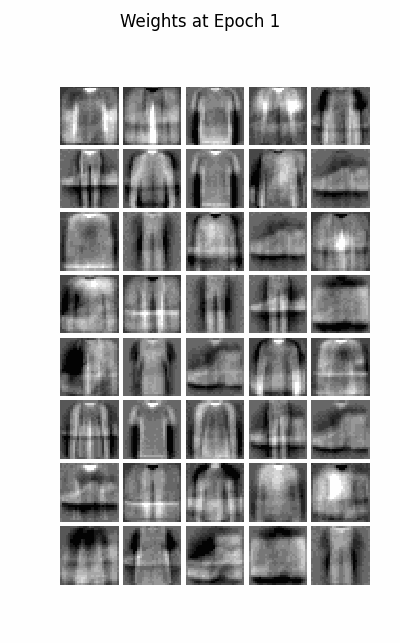

In [7]:
gif_file = 'imgs/weights.gif'
create_and_store_gif(gif_file)
embed.embed_file(gif_file)

Obserwując rozkład wag dla poszczególnych neuronów warstwy ukrytej względem warstwy widocznej można zauważyć, że wizualizacja tych wag przypomina różne elementy zbioru danych `Fashion-MNIST`. Co więcej, z każdą epoką obraz przedmiotu staje się coraz bardziej wyraźny.  
Wskazuje to na swoistą specjalizację poszczególnych neuronów w warstwy ukrytej w ekstrakcji cech charakterystycznych konkretnej klasy danych wejściowych.  
Brak jest widocznego rozbicia na elementy bardziej podstawowe, typu proste, łuki, koła itp., natomiast istnieją kafelki, jak np. pierwszy i piąty w czwartym rzędzie, w których ciężko rozpoznać pojedyńczą część garderoby, lecz wagi kładą nacisk na kształt wspólny dla kliku rodzajów ubrań. 

In [8]:
def plot_reconstruction(original, reconstructed):
    num_images = min(10, original.shape[0])
    size = original.shape[1]
    plt.figure(figsize=(20, 4))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(int(np.sqrt(size)), -1), cmap='gray')
        plt.title(f"Orig {i}")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(int(np.sqrt(size)), -1), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

def compute_ssim(original, reconstructed):
    data_range = 1.0
    num_images = original.shape[0]
    size = original.shape[1]
    ssim_values = []
    for i in range(num_images):
        orig_img = original[i].reshape(int(np.sqrt(size)), -1)
        recon_img = reconstructed[i].reshape(int(np.sqrt(size)), -1)
        ssim_values.append(ssim(im1=orig_img, im2=recon_img, data_range=data_range))
    return np.mean(ssim_values)

In [9]:
all_cats_reps_ids = [27, 2, 16, 13, 6, 8, 4, 9, 18, 0]
print(np.array(y_test)[all_cats_reps_ids])

test_dataset = append_ones(X_test)
all_cats_reps = test_dataset[all_cats_reps_ids]
reconstructed_all_cats_reps = rbm.reconstruct(all_cats_reps)

[0 1 2 3 4 5 6 7 8 9]


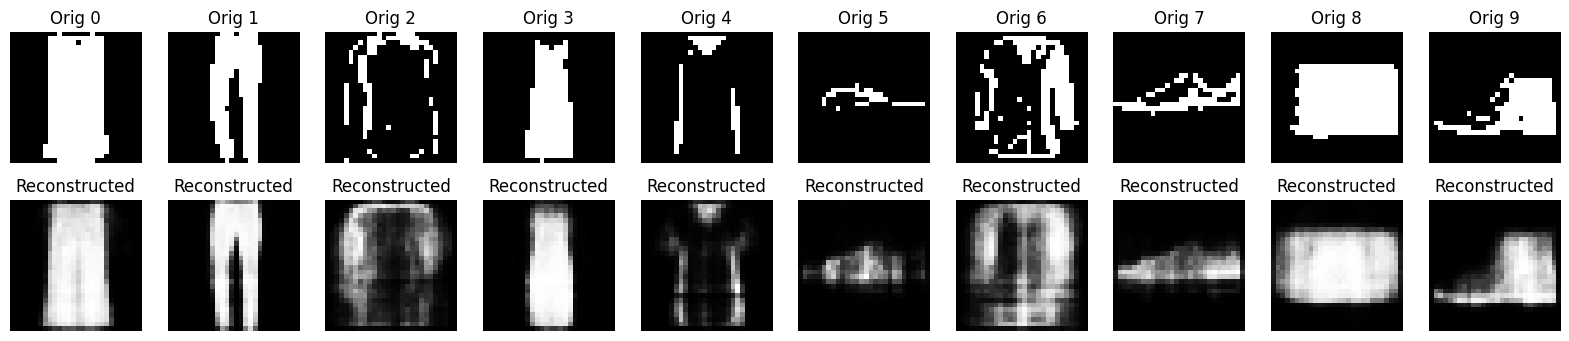

In [10]:
plot_reconstruction(all_cats_reps[:, :-1], reconstructed_all_cats_reps)

In [11]:
compute_ssim(all_cats_reps[:, :-1], reconstructed_all_cats_reps)

np.float64(0.5285589711841038)

In [17]:
rbm = RBM(visible_dim=visible_dim, hidden_dim=256)
dataset = append_ones(X_train)
rbm.fit(dataset, epochs=100)

Epoch 1:	##################################################	elapsed: 3.70s, reconstruction error: 38.50
Epoch 2:	##################################################	elapsed: 3.82s, reconstruction error: 32.59
Epoch 3:	##################################################	elapsed: 4.11s, reconstruction error: 29.98
Epoch 4:	##################################################	elapsed: 3.97s, reconstruction error: 28.54
Epoch 5:	##################################################	elapsed: 3.81s, reconstruction error: 27.42
Epoch 6:	##################################################	elapsed: 3.93s, reconstruction error: 26.62
Epoch 7:	##################################################	elapsed: 3.96s, reconstruction error: 26.05
Epoch 8:	##################################################	elapsed: 3.87s, reconstruction error: 25.69
Epoch 9:	##################################################	elapsed: 4.00s, reconstruction error: 25.28
Epoch 10:	##################################################	ela

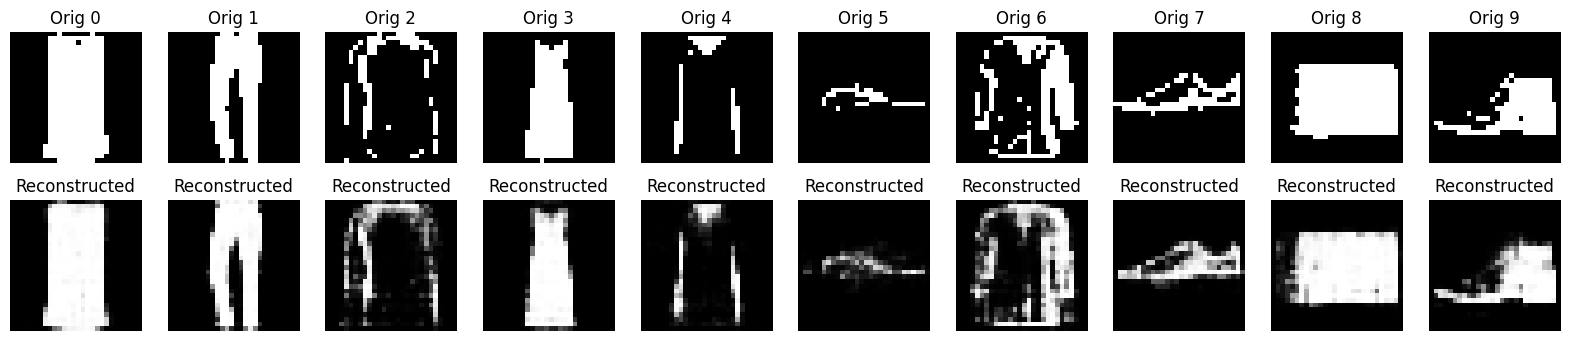

np.float64(0.7894349095803779)

In [18]:
better_reconstructed_all_cats_reps = rbm.reconstruct(all_cats_reps)
plot_reconstruction(all_cats_reps[:, :-1], better_reconstructed_all_cats_reps)
compute_ssim(all_cats_reps[:, :-1], better_reconstructed_all_cats_reps)

Jak widzimy, wyniki dla pojemniejszego modelu trenowanego dłuższy czas są dużo lepsze, zarówno wizualnie jak i użwając wskazania metryki SSIM.